# FLX_JP-BBY
partition FLUXNET-CH4 data from Bibai bog into diffusive and ebullitive fluxes

In [1]:
import pandas as pd
import numpy as np
import pywt
import wavefuncs as wave
import plotter as p

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from numpy.polynomial import Polynomial as P
from sklearn.linear_model import LinearRegression

In [2]:
# global plotting settings
plt.style.use('ggplot')
# text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1') 

## Import data and process

In [3]:
df = wave.pd_read_from_drive('FLX_JP-BBY') # read from google drive into pd.DataFrame

In [4]:
df = df.replace(-9999, np.nan) # replace missing with nan
df['date'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M') # parse timestamp to new column 'date'
df = df.set_index(df['date'])

plot entire FCH4 series vs time

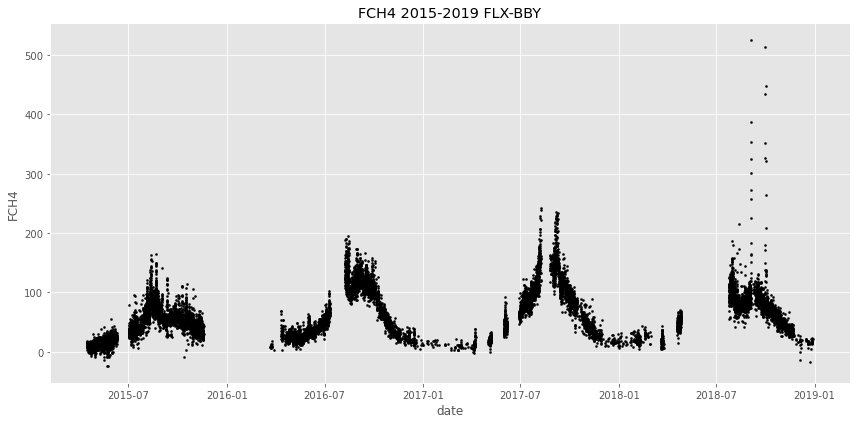

In [5]:
p.scatterdate(df.index, df['FCH4'], xlabel='date', ylabel='FCH4', title="FCH4 2015-2019 FLX-BBY")

ebullition ~2018-08?

In [6]:
dfw = df.loc['2018-07-01':'2019-01-01']

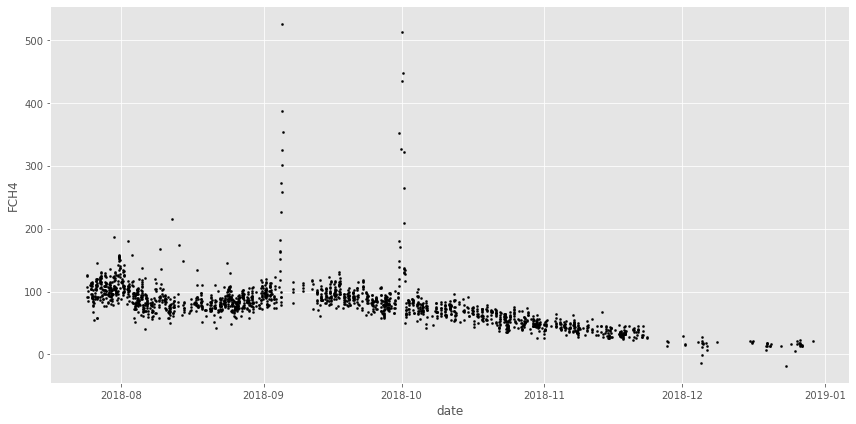

In [7]:
p.scatterdate(dfw.index, dfw['FCH4'], xlabel = 'date', ylabel = 'FCH4')

trim off Dec and sparse regions in Nov 

In [8]:
dfw = dfw.loc['2018-08-01':'2018-11-22']
dfw = dfw.loc[dfw['FCH4'].first_valid_index():dfw['FCH4'].last_valid_index()]
dfw.tail()

,TIMESTAMP_START,TIMESTAMP_END,NEE,H,LE,FCH4,USTAR,SW_IN,SW_OUT,LW_IN,...,G_F,WTD_F,WS_F,LE_F_ANNOPTLM,NEE_F_ANNOPTLM,FCH4_F_ANNOPTLM,FCH4_F_RANDUNC,FCH4_F_ANNOPTLM_UNC,FCH4_F_ANNOPTLM_QC,date
date,,,,,,,,,,,,,,,,,,,,,
2018-11-22 08:30:00,201811220830,201811220900,NaN,10.299,NaN,27.759,0.117947,162.733,30.072,250.470,...,-8.4635,-0.033667,1.173,8.881268,-0.002383,27.759,14.054628,NaN,1,2018-11-22 08:30:00
2018-11-22 09:00:00,201811220900,201811220930,0.24140,19.067,NaN,27.083,0.128069,220.863,30.408,264.760,...,-8.5348,-0.033667,1.492,12.958019,0.241400,27.083,13.862763,NaN,1,2018-11-22 09:00:00
2018-11-22 09:30:00,201811220930,201811221000,1.07490,51.908,44.564,44.661,0.154567,271.138,36.671,268.875,...,-8.5913,-0.033667,1.330,44.564000,1.074900,44.661,10.889463,NaN,1,2018-11-22 09:30:00
2018-11-22 10:00:00,201811221000,201811221030,0.37500,38.059,32.652,37.238,0.118917,221.318,23.119,287.204,...,-8.6442,-0.033333,1.470,32.652000,0.375000,37.238,10.391490,NaN,1,2018-11-22 10:00:00
2018-11-22 10:30:00,201811221030,201811221100,-0.44658,18.734,20.402,30.939,0.101577,159.709,12.566,293.984,...,-8.6673,-0.033333,1.075,20.402000,-0.446580,30.939,14.003261,NaN,1,2018-11-22 10:30:00


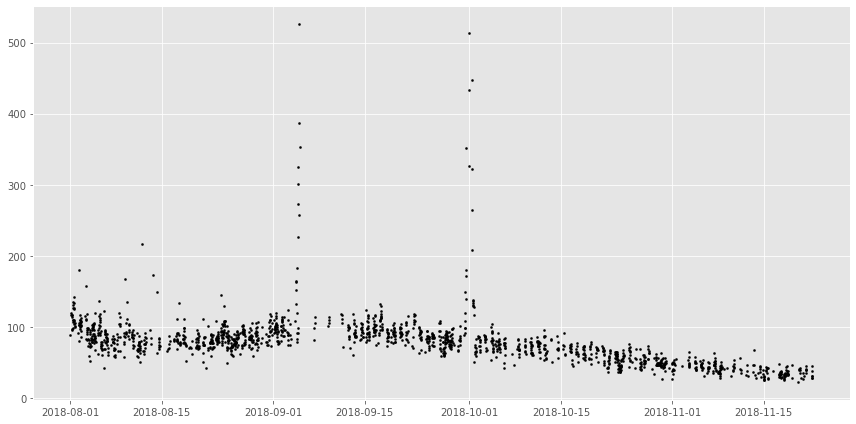

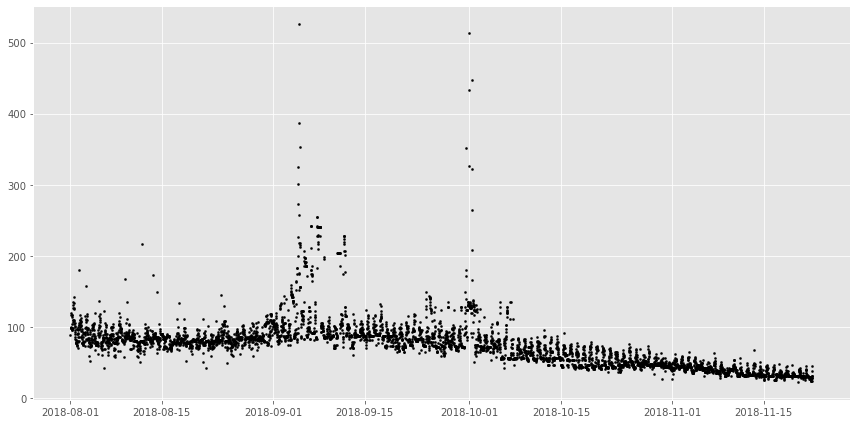

In [9]:
p.scatterdate(dfw.index, dfw['FCH4'])
p.scatterdate(dfw.index, dfw['FCH4_F'])

gap-filling adding some info after first big spike (~mid Sept), but I'll use it and see what happens

In [10]:
# normalize
nM, [xpM, ypM] = wave.norm(dfw.loc[:, 'FCH4_F'].to_numpy())
nLE, [xpLE, ypLE] = wave.norm(dfw.loc[:, 'LE_F'])
nT, [xpT, ypT] = wave.norm(dfw.loc[:, 'TA_F'])

In [11]:
# add normalized series to df
df.loc[dfw.index, 'FCH4_Fn'] = nM
df.loc[dfw.index, 'LE_Fn'] = nLE
df.loc[dfw.index, 'TA_Fn'] = nT

In [12]:
# compute wavelet coefficients using MODWT
[cM, cT, cLE] = wave.mra8(df.loc[dfw.index, ['FCH4_Fn', 'TA_Fn', 'LE_Fn']].to_numpy(), level=7, axis=0)

In [13]:
# sum wavelet scales and calculate scale windows
csumM, scalesM = wave.sum_scales(cM)
csumT, scalesT = wave.sum_scales(cT)
csumLE, scalesLE = wave.sum_scales(cLE)

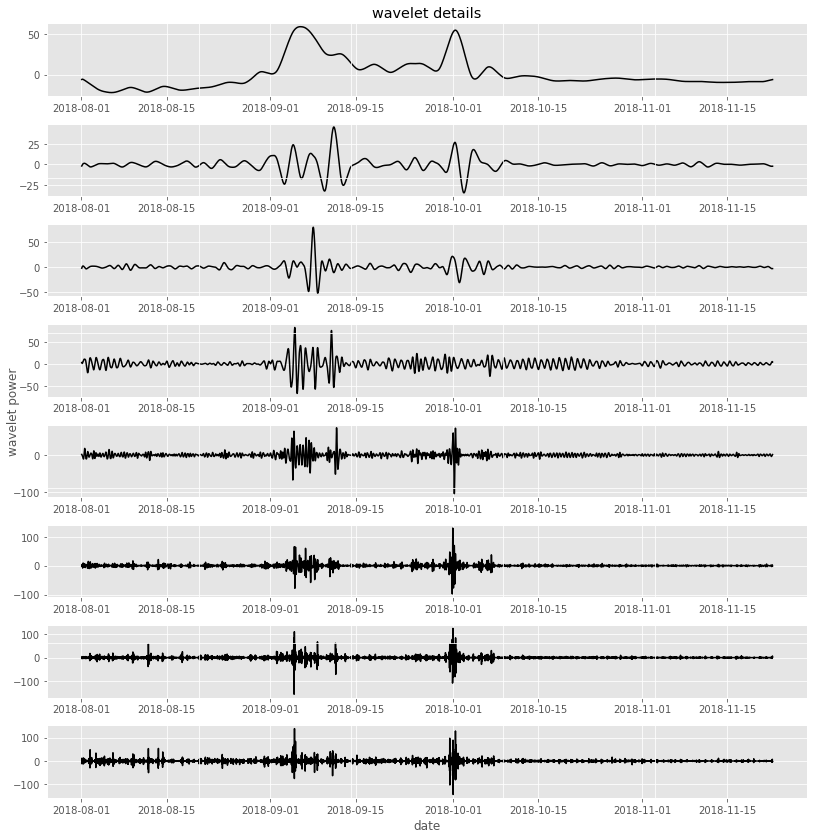

In [14]:
p.wavelet(dfw.index, cM)

InvalidIndexError: DatetimeIndex(['1970-01-01 00:00:00.000005443',
               '1970-01-01 00:00:00.000001360',
               '1970-01-01 00:00:00.000000680',
               '1970-01-01 00:00:00.000000453'],
              dtype='datetime64[ns]', freq=None)

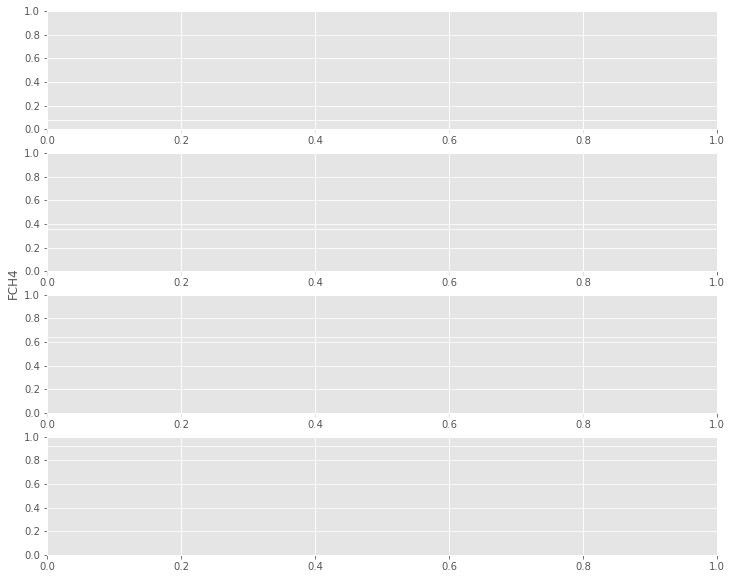

In [15]:
p.reconst(df.loc[dfw.index, 'FCH4_F'], csumM, scalesM, '2018-09-05', ypM, ylabel = 'FCH4')

In [ ]:
zdate = pd.to_datetime('2018-09-05')

In [ ]:
p.wavelet(dfw.index, cLE)

KeyError: 'FCH4_w0d'

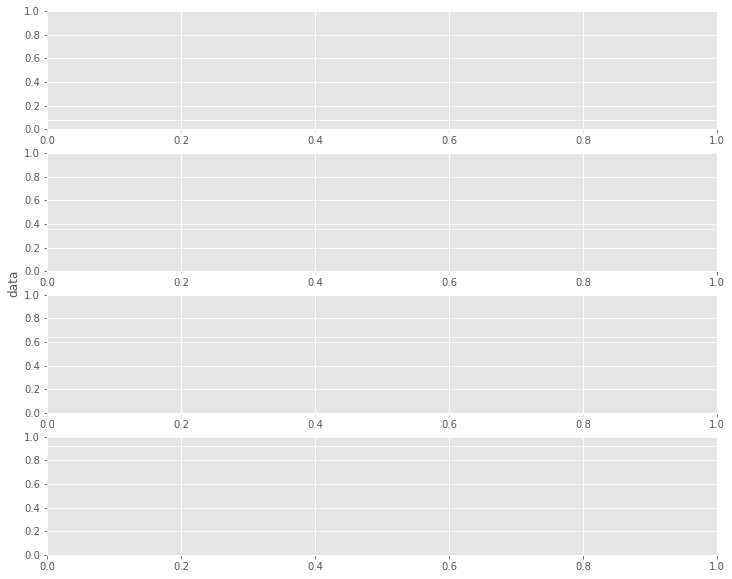

In [16]:
p.reconst(df.loc[dfw.index], csumLE, '2018-09-05', ypLE)

In [17]:
df.loc[dfw.index, ['FCH4_w{}'.format(j) for j in range(len(csumM))]] = np.array(csumM).T

df.loc[dfw.index, ['LE_w{}'.format(j) for j in range(len(csumLE))]] = np.array(csumLE).T

df.loc[dfw.index, ['TA_w{}'.format(j) for j in range(len(csumT))]] = np.array(csumT).T

In [18]:
# flatten lists of wavelet coefficients
cMflat = np.concatenate(csumM).ravel().reshape(-1, 1)
cLEflat = np.concatenate(csumLE).ravel().reshape(-1, 1)

In [19]:
LS = LinearRegression().fit(cLEflat, cMflat)

In [20]:
from sklearn.metrics import mean_squared_error

pred = LS.predict(cLEflat)
rmsd = np.sqrt(mean_squared_error(cMflat, pred))
rmsd

14.154858609249343

In [21]:
for j in range(len(csumM)):
    FCH4w = df.loc[dfw.index, 'FCH4_w{}'.format(j)].to_numpy().reshape(-1, 1)
    predw = pred[j*len(dfw.index):j*len(dfw.index) + len(dfw.index)]
    for i in range(len(dfw.index)):
        if (FCH4w[i] < predw[i] + 3*rmsd) & (FCH4w[i] > predw[i] - 3*rmsd):
            df.loc[dfw.index[i], 'FCH4_w{}d'.format(j)] = 1.
        else:
            df.loc[dfw.index[i], 'FCH4_w{}d'.format(j)] = 0.

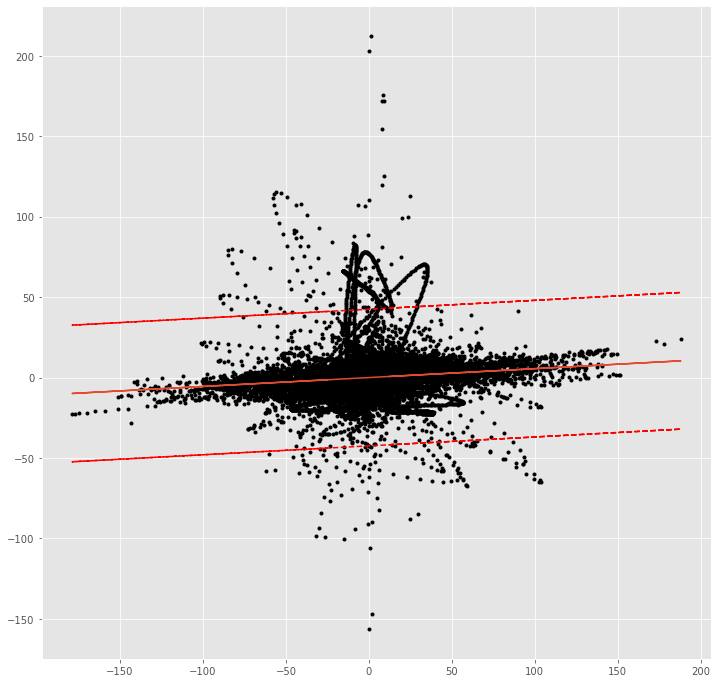

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (12,12))

ax.plot(cLEflat, cMflat, 'k.',
        cLEflat, LS.predict(cLEflat),
        cLEflat, LS.predict(cLEflat) + 3*rmsd, 'r--',
        cLEflat, LS.predict(cLEflat) - 3*rmsd, 'r--')

plt.show()

In [23]:
cMpd = pd.DataFrame(csumM).transpose()
cLEpd = pd.DataFrame(csumLE).transpose()

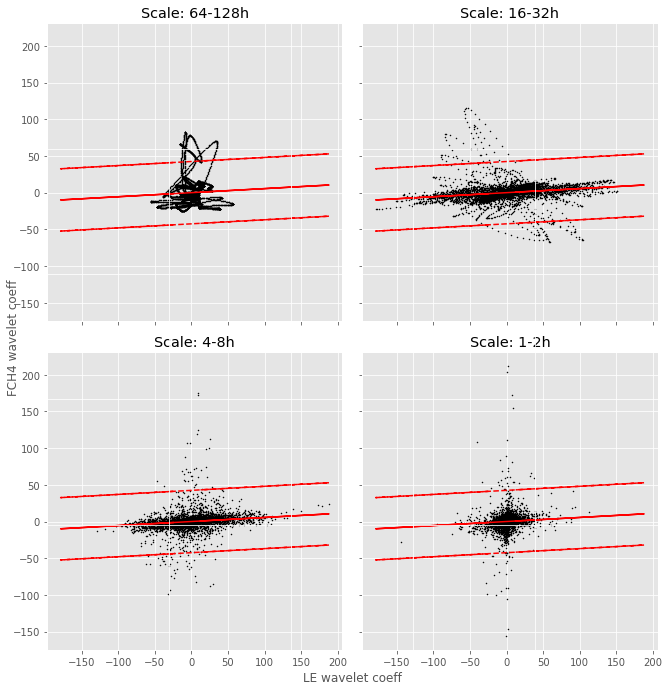

In [24]:
p.scattercoef(cLEpd, cMpd, cLEflat, pred, rmsd, xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff')

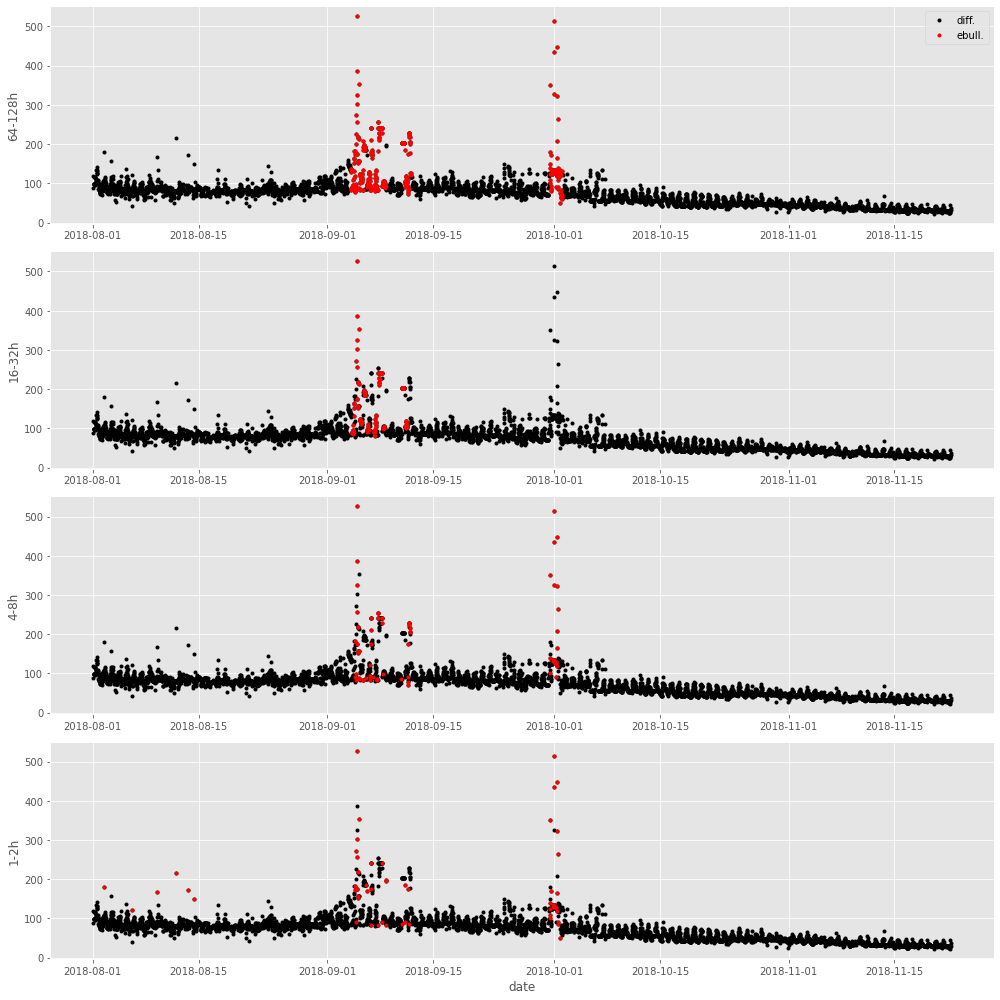

In [25]:
fig, ax = plt.subplots(4, 1, figsize=(14,14))

for j in range(4):
    ax[j].plot(dfw.index, df.loc[dfw.index, 'FCH4_F'], 'k.',
           df.loc[df['FCH4_w{}d'.format(j)]==0].index, df.loc[df.loc[df['FCH4_w{}d'.format(j)]==0].index, 'FCH4_F'], 'r.')
    ax[3-j].set(ylabel = '{0}-{1}h'.format(2**(2*j),2**(2*j)*2))
    
ax[-1].set_xlabel('date')
ax[0].legend(['diff.', 'ebull.'])
#plt.savefig('plot/20210603_part_BBY.jpeg')
plt.tight_layout()
plt.show()

## junk

In [32]:
def reconst(data, c, zdate, yp, xlabel = 'date', ylabel='data',
            figsize=(12,10), filename = None):
    '''Plots wavelet details and data at different time scales for specified date range
    Parameters
    ----------
    data : pd.Series with DatetimeIndex
    	original data series
    c : list of ndarray
    	wavelet coefficients as returned by 'pywt.wavedec' or 'mra'
    scales : list of int
        specified timescales in indices
    zdate : str
      	date to center zoom
    yp : ndarray
    	y linspace of fit used for normalization
    xlabel, ylabel, title : str
        passed to plt
    figsize : tuple
        size of plot, passed to plt
    filename : str or None
        passed to plt.savefig
    Notes
    -----
    This sums wavelet detail and yp to align wavelet with data for plotting. 
    I'm not sure if that's physical or meaningful.
    Time scales zoom centered on the same date.
    '''
    fig, ax = plt.subplots(len(c), 1, figsize=figsize)

    # add a big axis, hide frame
    bigax = fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    bigax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    bigax.set_ylabel(ylabel)
    
    for i in range(len(c)):
        
        win = int(len(data.index)/((i+1)*4))
        center = data.index.get_loc(pd.to_datetime(zdate))
        
        [start, stop] = [int(center-win/2),
                         int(center+win/2)]
    
        ax[len(c)-1-i].plot(data.iloc[start:stop].index, data['FCH4_F'].iloc[start:stop], 'k.',
                          data.loc[data['FCH4_w{}d'.format(i)]==0].index, 
                          data.loc[data.loc[data['FCH4_w{}d'.format(i)]==0].index,
                                  'FCH4_w{}'.format(i)],'r-.',
                          data.loc[data['FCH4_w{}d'.format(i)]==0].index, 
                          data.loc[data.loc[data['FCH4_w{}d'.format(i)]==0].index,
                                  'FCH4_w{}'.format(i)],'g-',
                          )
    
    ax[0].set(title="{} and wavelet detail".format(ylabel))
    ax[0].legend([ylabel, 'wavelet detail'])
    ax[-1].set_xlabel(xlabel)
    plt.tight_layout()
    
    
    if filename is not None:
        plt.savefig(filename)
    
    plt.show()
    return



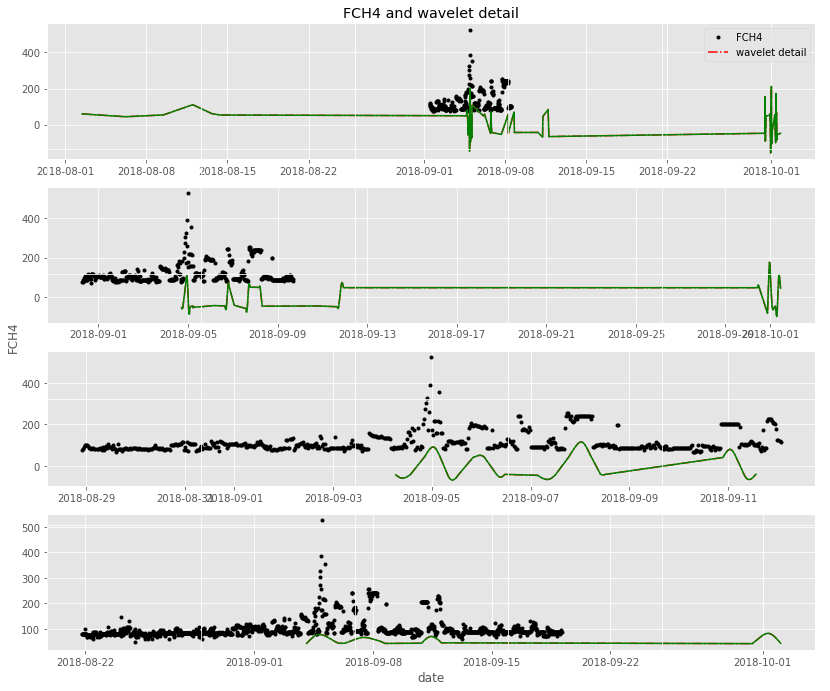

In [33]:
reconst(df.loc[dfw.index], csumM, '2018-09-05', ypM, ylabel = 'FCH4')

In [116]:
u = ((cMflat - pred) ** 2).sum()
mse2 = u / len(cMflat)

print('mse: {}'.format(mse))
print('mse2: {}'.format(mse2))

mse: 200.36002224784028
mse2: 200.36002224784028


In [111]:
v = ((cMflat - cMflat.mean()) ** 2).sum()
Rsq = 1-(u/v)
print(Rsq)
print(LS.score(cLEflat, cMflat))

0.012559804682866438
0.012559804682866438
